In [1]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, jaccard_score, f1_score
from PIL import Image


In [2]:
# Define the model architecture
def BCDU_net_D3(input_tensor=None):
    if input_tensor is None:
        inputs = Input(shape=(256, 256, 3))
    else:
        inputs = input_tensor

    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conc1 = concatenate([inputs, conv1], axis=3)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conc1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conc2 = concatenate([pool1, conv2], axis=3)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conc2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conc3 = concatenate([pool2, conv3], axis=3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conc3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conc4 = concatenate([pool3, conv4], axis=3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conc4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

In [3]:
# Function to preprocess the user input image
def preprocess_input_image(image_path):
    img = Image.open(image_path)
    img = img.resize((256, 256))
    img_array = np.array(img)
    img_array = img_array / 255.0  # Normalize the image
    return img_array


In [5]:
# Load the trained model weights
model = BCDU_net_D3()
model.load_weights('weight_isic18')
# Create the folder to save predicted images if it doesn't exist
predicted_images_folder = 'predicted_images'
if not os.path.exists(predicted_images_folder):
    os.makedirs(predicted_images_folder)

In [10]:

# Function to predict mask for user input image and save it
def predict_and_save_mask(image_path, model, save_folder):
    img = preprocess_input_image(image_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    mask = model.predict(img)[0]  # Remove batch dimension
    mask_image = (mask.squeeze() * 255).astype(np.uint8)
    # Display the predicted mask image
    plt.imshow(mask_image, cmap='gray')
    plt.title("Predicted Mask of Input Image:\n")
    plt.axis('off')
    plt.show()
    # Save the predicted mask image
    image_name = os.path.basename(image_path)
    mask_image_path = os.path.join(save_folder, f'{image_name.split(".")[0]}_mask.png')
    Image.fromarray(mask_image).save(mask_image_path)
    print(f"Predicted mask saved at: {mask_image_path}")

Enter the Image Path:
/Users/shravanisajekar/Desktop/dataset/ISIC2018_Task1-2_Validation_Input/ISIC_0023678.jpg
1/1 [==============================] - 0s 40ms/step


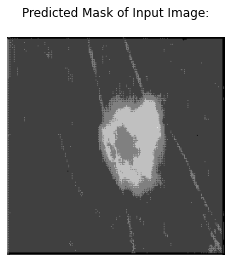

Predicted mask saved at: predicted_images/ISIC_0023678_mask.png


In [11]:
# Example usage:
input_image_path = input("Enter the Image Path:\n")
predict_and_save_mask(input_image_path, model, predicted_images_folder)